In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from scipy import special

# Define range of complex numbers
RE_START = -2
RE_END = 0.5
IM_START = -1.1
IM_END = 1.1

# Compute Mandelbrot set as f_c(z) = z^2 + c while z is in 
# range [-2, 2] and n below the maximum number of iterations
def mandelbrot(c, max_iter):
    z = n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
    return n

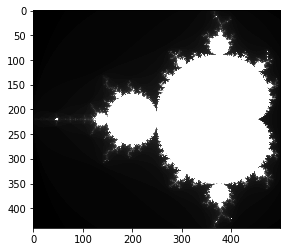

In [2]:
# Compute number of iterations possible in Mandelbrot calculation for 
# complex numbers in range [RE_START + IM_START * i, RE_END + IM_END * i]
image = np.zeros((440, 500))
for x, y in np.ndindex(image.shape):
    c = complex(RE_START + (y / image.shape[1]) * (RE_END - RE_START),
                    IM_START + (x / image.shape[0]) * (IM_END - IM_START))
    image[x,y] = mandelbrot(c, 100)
    
plt.imshow(image, cmap='gray')
plt.show()

In [92]:
# Take s Monte Carlo samples from the Mandelbrot set
def monte_carlo_integration(i=100, s=100, sampling_method='random'):
    if sampling_method == 'latin_hypercube':
        samples = latin_hypercube_sampling(s)
    elif sampling_method == 'orthogonal':
        samples = orthogonal_sampling(s)
    else:
        samples = np.random.random((s,2))
    
    samples[:,0] = samples[:,0] * (RE_END - RE_START) + RE_START
    samples[:,1] = samples[:,1] * (IM_END - IM_START) + IM_START

    n = np.vectorize(mandelbrot)(samples.view(dtype=np.complex128), i)
    return (n == i).sum() / s * (RE_END - RE_START) * (IM_END - IM_START)

In [185]:
def monte_carlo_integration_given_samples(i, samples):
    samples = np.copy(samples)
    samples[:,0] = samples[:,0] * (RE_END - RE_START) + RE_START
    samples[:,1] = samples[:,1] * (IM_END - IM_START) + IM_START

    n = np.vectorize(mandelbrot)(samples.view(dtype=np.complex128), i)
    return (n == i).sum() / len(samples) * (RE_END - RE_START) * (IM_END - IM_START)

In [90]:
def latin_hypercube_sampling(n_samples, n_dimensions=2):
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([np.random.permutation(range(n_samples)) for _ in range(n_dimensions)]).T
    return (samples + perms) / n_samples

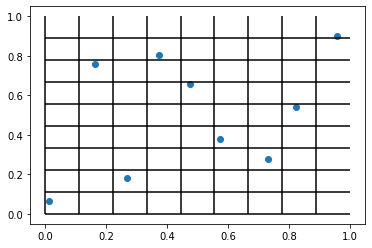

In [154]:
n = 3**2
s = latin_hypercube_sampling(n)
plt.figure()
plt.hlines(np.arange(n)/n, 0, 1)
plt.vlines(np.arange(n)/n, 0, 1)
plt.scatter(s[:,0], s[:,1])
plt.show()

In [4]:
def orthogonal_sampling(n_samples, n_dimensions=2):
    n_subspaces = np.sqrt(n_samples)
    if round(n_subspaces) != n_subspaces:
        raise ValueError('Square root of number of samples not a whole number')
    
    xlist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    ylist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    
    for i in range(len(xlist)):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([[xlist[index], ylist[index[::-1]]] for index,_ in np.ndenumerate(xlist)])
    return (samples + perms) / n_samples

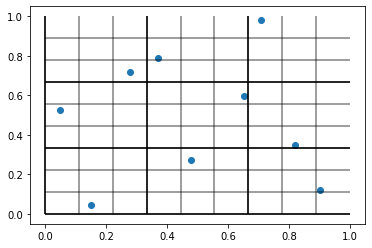

In [5]:
n = 3**2
s = orthogonal_sampling(n)
plt.figure()
plt.hlines(np.arange(n)/n, 0, 1, alpha=0.5)
plt.vlines(np.arange(n)/n, 0, 1, alpha=0.5)
plt.hlines(np.arange(np.sqrt(n))/np.sqrt(n), 0, 1)
plt.vlines(np.arange(np.sqrt(n))/np.sqrt(n), 0, 1)
plt.scatter(s[:,0], s[:,1])
plt.show()

## Plotting the area

In [185]:
def plot_samples(s_list, iterations=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip([iterations]*len(s_list), s_list)))
    plt.plot(s_list, areas, '.', label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, s_list[0], s_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Samples")
    plt.ylabel("Surface area")
    plt.yscale('log')
    # plt.savefig("Convergence_samples", dpi=500)
    plt.legend()
    plt.show()

    pool.close()

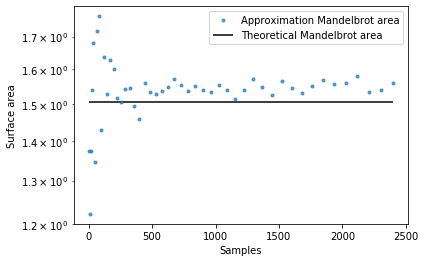

In [186]:
plot_samples(np.arange(1,50)**2, 100, 'orthogonal')

In [183]:
def plot_iterations(i_list, samples=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())
    
    areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(i_list, [samples]*len(i_list))))
    plt.plot(i_list, areas, '.', label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, i_list[0], i_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Iterations")
    plt.ylabel("Surface area")
    plt.yscale('log')
    plt.legend()
    # plt.savefig("Convergence_iterations.png", dpi=500)
    plt.show()
    
    pool.close()

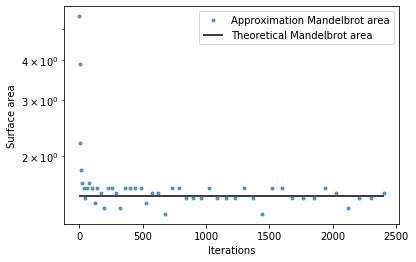

In [184]:
plot_iterations(np.arange(1,50)**2, 100, 'orthogonal')

In [ ]:
def plot_samples_and_iterations(s_list, i_list, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())
    # TODO
    

## Plotting the variance

In [43]:
def plot_samples_variance(s_list, iterations=100, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(s_list, [iterations]*len(s_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    variance = np.var(all_areas, axis=0)

    plt.plot(s_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, s_list[0], s_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Samples")
    plt.ylabel("Surface area")
    plt.yscale('log')
    plt.fill_between(s_list, mean - variance, mean + variance, alpha = 0.3)
    plt.legend()
    # plt.savefig("Convergence_iterations_variance.png", dpi=500)
    plt.show()

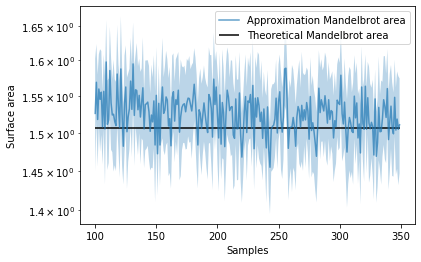

Process ForkPoolWorker-62:
Process ForkPoolWorker-64:
Process ForkPoolWorker-61:
Process ForkPoolWorker-63:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/U

In [44]:
plot_samples_variance(np.arange(100,350))

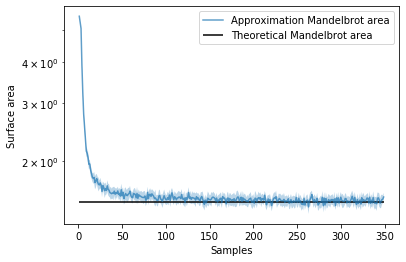

Process ForkPoolWorker-68:
Process ForkPoolWorker-67:
Process ForkPoolWorker-66:
Process ForkPoolWorker-65:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/U

In [45]:
plot_samples_variance(np.arange(1,350))

In [47]:
def plot_iterations_variance(i_list, samples=100, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(i_list, [samples]*len(i_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    variance = np.var(all_areas, axis=0)

    plt.plot(i_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, i_list[0], i_list[-1], label = "Theoretical Mandelbrot area")
    plt.xlabel("Iterations")
    plt.ylabel("Surface area")
    plt.yscale('log')
    plt.fill_between(i_list, mean - variance, mean + variance, alpha = 0.3)
    plt.legend()
    # plt.savefig("Convergence_iterations_variance.png", dpi=500)
    plt.show()

In [50]:
plot_iterations_variance(np.arange(100,100000, 100))

Process ForkPoolWorker-114:
Process ForkPoolWorker-113:
Process ForkPoolWorker-115:
Process ForkPoolWorker-116:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func

## Boxplots

In [375]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['caps'][1], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['whiskers'][1], color='blue')
    plt.setp(bp['medians'][0], color='blue')

    plt.setp(bp['boxes'][1], color='red')
    plt.setp(bp['caps'][2], color='red')
    plt.setp(bp['caps'][3], color='red')
    plt.setp(bp['whiskers'][2], color='red')
    plt.setp(bp['whiskers'][3], color='red')
    plt.setp(bp['medians'][1], color='red')
    
    plt.setp(bp['boxes'][2], color='green')
    plt.setp(bp['caps'][4], color='green')
    plt.setp(bp['caps'][5], color='green')
    plt.setp(bp['whiskers'][4], color='green')
    plt.setp(bp['whiskers'][5], color='green')
    plt.setp(bp['medians'][2], color='green')

def boxplot_samples_variance(s_list, iterations=100, runs=200):
    pool = mp.Pool(mp.cpu_count())

    areas = np.zeros((len(s_list),3,runs))
    for index, samples in enumerate(s_list):
        areas[index][0] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='random'), [iterations]*runs))])
        areas[index][1] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='latin_hypercube'), [iterations]*runs))])        
        areas[index][2] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='orthogonal'), [iterations]*runs))])        

    fig = plt.figure()
    ax = plt.axes()

    bp = plt.boxplot(areas[0].T, positions=[1,2,3], widths = 0.6, sym='')
    setBoxColors(bp)

    bp = plt.boxplot(areas[1].T, positions=[5,6,7], widths = 0.6, sym='')
    setBoxColors(bp)

    bp = plt.boxplot(areas[2].T, positions=[9,10,11], widths = 0.6, sym='')
    setBoxColors(bp)

    plt.xlabel('Samples')
    ax.set_xticklabels(s_list)
    ax.set_xticks([2, 6, 10])
    plt.ylabel('Area')
    
    hB, = plt.plot([1,1],'b-')
    hR, = plt.plot([1,1],'r-')
    hG, = plt.plot([1,1], 'g-')
    plt.legend((hB, hR, hG),('Uniform', 'Latin Hypercube', 'Orthogonal'))
    hB.set_visible(False)
    hR.set_visible(False)
    hG.set_visible(False)

    plt.show()
    pool.close()

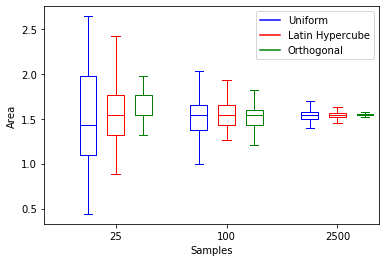

In [378]:
boxplot_samples_variance(np.array([25, 100, 2500]))

## Variance Reduction

In [98]:
def antithetic_monte_carlo_integration(i=100, s=100, sampling_method='randomn'):
    if sampling_method == 'latin_hypercube':
        samples = latin_hypercube_sampling(s)
    elif sampling_method == 'orthogonal':
        samples = orthogonal_sampling(s)
    else:
        samples = np.random.random((s,2))
        
    antithetic_samples = np.copy(samples)
    antithetic_samples[:,0] = 1 - antithetic_samples[:,0]
    
    areas = monte_carlo_integration_given_samples(i, samples)
    antithetic_areas = monte_carlo_integration_given_samples(i, antithetic_samples)
    
    return (areas + antithetic_areas) / 2

In [113]:
print(antithetic_monte_carlo_integration(sampling_method='latin_hypercube'))

1.54


In [260]:
def control_variates(i=100, s=100, runs=100, sampling_method='random'):
    X = np.zeros(runs)
    Y = np.zeros(runs)
    for i in range(runs):
        if sampling_method == 'latin_hypercube':
            samples = latin_hypercube_sampling(s)
        elif sampling_method == 'orthogonal':
            samples = orthogonal_sampling(s)
        else:
            samples = np.random.random((s,2))

        X[i] = monte_carlo_integration_given_samples(i, samples)
        Y[i] = np.mean(samples[:,0] + samples[:,1])
    
    print(np.var(X))
    print(np.cov(X,Y))
        
    c = - np.cov(X,Y)[0,1] / (1/6)
    return X + c * (Y - 1)

In [261]:
print(np.var(control_variates()))

0.6422087099999999
[[0.64869567 0.00218853]
 [0.00218853 0.00148749]]
0.642152062796674
